# Joint spectrum fit with systematics

In this notebook, we re-execute the joint spectrum fit including systematics
on the per-instrument energy scales, as described in the paper and scripted
in ``joint_crab/fit_systematics.py``. Please see the paper for a description
of the likelihood function and parameters.

First we illustrate the effect of the energy scale on the spectral model.
After the fit, we show the parameter correlations, and we show a plot
illustrating the energy scale shifts for each instrument.

In [66]:
%matplotlib inline
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
#from multinorm import MultiNorm
from gammapy.modeling import Fit, Parameter
from gammapy.datasets import Datasets
from gammapy.modeling.models import LogParabolaSpectralModel, SkyModel
from joint_crab.energy_bias_model import EnergyBiasSpectralModel
#from joint_crab.fit_systematics import SystematicsSpectrumFit

## Energy scale shift

Let us see how the log-parabolic spectrum is modified by an energy scale shift of $\pm20\%$.

For negative energy scale factor `z` the spectrum is shifted to lower energies,
for positive `z` to higher energies.

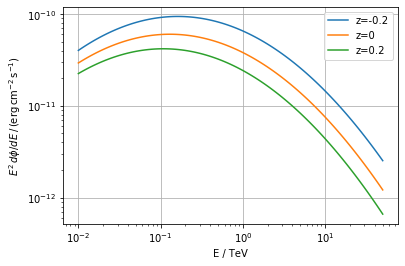

In [67]:
log_parabola = LogParabolaSpectralModel(
    amplitude="3.8e-11 cm-2s-1TeV-1", 
    reference=1*u.TeV,
    alpha=2.45, 
    beta=0.11
)

for z in [-0.2, 0, +0.2]:
    model = EnergyBiasSpectralModel(log_parabola, "bias", z)
    model.plot([0.01, 50] * u.TeV, energy_power=2, label=f"z={z}")

plt.legend()
plt.xlabel("E / TeV")
plt.ylabel(
    r"$E^2\,d\phi/dE\,/\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$"
)
plt.grid()

In [101]:
# Define priors on Datasets
class GaussianLogPrior:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
    
    def __call__(self, value):
        return (value-self.mean)**2/self.sigma**2

class UniformLogPrior:
    def __init__(self, min_value, max_value):
        self.min = min_value
        self.max = max_value
        self.norm = 2*np.log(max_value-min_value)
    
    def __call__(self, value):
        if value>self.min & value<=self.max:
            return self.norm
        else:
            return 0.
    
def set_log_prior(self, prior):
    self._log_prior=prior

def log_prior(self):
    if hasattr(self, "_log_prior"):
        return self._prior(self.value)
    else:
        return 1.
    
Parameter.set_prior = set_prior
Parameter.log_prior = log_prior

def stat_sum(self):
    """Compute joint likelihood"""
    stat_sum = 0
    # TODO: add parallel evaluation of likelihoods
    for dataset in self:
        stat_sum += dataset.stat_sum()
    for param in self.parameters:
        stat_sum += param.log_prior()
    return stat_sum

Datasets.stat_sum = stat_sum

In [96]:
def read_datasets_and_set_model(instrument, model):
    # Read from disk
    datasets = Datasets.read(f"reduced_{instrument}/_datasets.yaml",
                             f"reduced_{instrument}/_models.yaml")

    # Set model and fit range
    for ds in datasets:
        ds.models = model
    return datasets._datasets

In [97]:
instruments = ["hess","magic","veritas","fact", "fermi"]
priors = [0.15,0.15,0.15,0.15, 0.05]
datasets = []
for instrument, prior in zip(instruments, priors):
    model = SkyModel(
        spectral_model=EnergyBiasSpectralModel(log_parabola, f"z_{instrument}", 0.),
        name=f"Crab_{instrument}"
    )
    prior_fcn = GaussianParameterPrior(0., 0.15)
    model.parameters[f"z_{instrument}"].set_prior(prior_fcn) 
    datasets.extend(read_datasets_and_set_model(instrument, model))

datasets=Datasets(datasets)

In [98]:
fit = Fit(datasets)
result = fit.run()
res=fit.covariance()

In [99]:
res.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
z_hess,-8.844e-02,3.209e-01,,-1.000e+00,2.000e+00,False
amplitude,3.601e-11,3.168e-11,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
alpha,2.504e+00,8.253e-02,,nan,nan,False
beta,1.066e-01,1.208e-02,,nan,nan,False
z_magic,-2.756e-02,3.421e-01,,-1.000e+00,2.000e+00,False
z_veritas,3.523e-03,3.535e-01,,-1.000e+00,2.000e+00,False
z_fact,4.949e-02,3.700e-01,,-1.000e+00,2.000e+00,False
z_fermi,5.475e-02,3.717e-01,,-1.000e+00,2.000e+00,False


## Plot

The spectral results with the modified likelihood are given in Figure 4 of the paper.

Here we plot the results for the energy-scale factors.

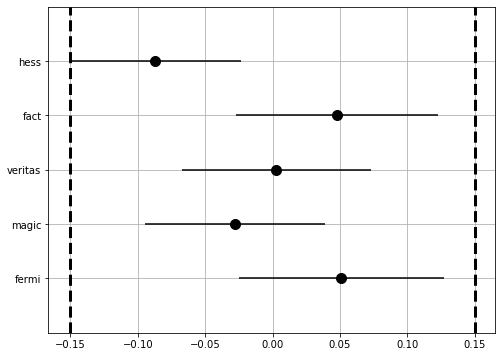

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))

names = ["fermi", "magic", "veritas", "fact", "hess"]

for y, name in enumerate(names):
    x = res.parameters[f"z_{name}"].value
    xerr = res.parameters.error(f"z_{name}")
    ax.errorbar(x, y, xerr=xerr, ls="-", marker="o", ms=10, color="k")

ax.set_ylim([-1, 5])
ax.set_yticks(list(range(5)))
ax.set_yticklabels(names)
ax.grid()
ax.axvline(0.15, color="k", lw=3, ls="--")
ax.axvline(-0.15, color="k", lw=3, ls="--");